## **Libraries and unpack data**

In [ ]:
!pip install pydicom
!pip install tabulate
!pip install seaborn
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from zipfile import ZipFile
import os
from tabulate import tabulate
import copy
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow
import math
from random import randint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
patient_paths = glob('3Dircadb1.*')

In [ ]:
with ZipFile('/content/gdrive/MyDrive/3Dircadb1.zip', 'r') as zipObj:
   # Get a list of all archived file names from the zip
   zipObj.extractall()

In [ ]:
%cd 3Dircadb1

/content/3Dircadb1


In [ ]:
%cd ".."

/content


In [ ]:
%cd  3Dircadb1

/content/3Dircadb1


In [ ]:
!ls

3Dircadb1.1   3Dircadb1.12  3Dircadb1.15  3Dircadb1.18	3Dircadb1.20  3Dircadb1.5  3Dircadb1.8
3Dircadb1.10  3Dircadb1.13  3Dircadb1.16  3Dircadb1.19	3Dircadb1.3   3Dircadb1.6  3Dircadb1.9
3Dircadb1.11  3Dircadb1.14  3Dircadb1.17  3Dircadb1.2	3Dircadb1.4   3Dircadb1.7


In [ ]:
# rename subdirectory from '3Dircadb1/3Dircadb1/3Dircadb1.1' to 1, and so on
for i in range(20):
  os.rename('3Dircadb1.'+str(i+1), str(i+1))

In [ ]:
# unzip all files
for i in range(20):
    # for each subdirectory '3Dircadb1/{i+1}', unzip all files with zip format
    parent = f'{i+1}'
    # unzip all files in parent
    for file in os.listdir(parent):
        if file.endswith('.zip'):
            # extract file without letting the original parent folder back
            with ZipFile(os.path.join(parent, file), 'r') as zipObj:
                zipObj.extractall(parent)

### **Data**

In [ ]:
%cd '..'

/content


In [ ]:
%cd '3Dircadb1'

/content/3Dircadb1


# Create Segmentation Label for YOLOv8

## Hàm để vẽ label-YOLOv8 lên ảnh tương ứng

In [ ]:
# Hàm draw_label_YOLOv8 nhận vào (đường dẫn cho ảnh, đường dẫn cho file annotation, và flag fillPoly)
# fillPoly == True để vẽ mask cho objects
# fillPoly == False để vẽ polygon bao quanh objects
def draw_label_YOLOv8(image_path, annot_path, fillPoly=False):
    with open(annot_path, 'r') as f:
        labels = f.read().splitlines()
    img = cv2.imread(image_path)
    h,w = img.shape[:2]

    for label in labels:
        class_id, *poly = label.split(' ')

        poly = np.asarray(poly,dtype=np.float16).reshape(-1,2) # Read poly, reshape
        poly *= [w,h] # Unscale

        if fillPoly:
            if class_id == "20":    # Pass all person
                continue
            cv2.fillPoly(img, [poly.astype('int')], (randint(0,255),randint(0,255),randint(0,255)), cv2.LINE_AA) # Draw mask
        else:
            cv2.polylines(img, [poly.astype('int')], True, (randint(0,255),randint(0,255),randint(0,255)), 2) # Draw Poly Lines
    cv2_imshow(img)

## Segmentation for human parts and human instance

In [ ]:
# Định nghĩa hàm tạo hình mới từ hình nhị phân cũ sao cho kết quả contours giảm đi một đường
# Tiền điều kiện: hình nhập vào nếu contour thì sẽ cho ra nhiều hơn 1 đường
def draw_additional_line(bin_img: np.ndarray, label: int) -> np.ndarray:
  # Tìm contours
  cons, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  # Tìm 2 điểm gần nhau nhất
  con01, con02 = cons[0], cons[1]
  min_ids = (0, 0)
  min = np.linalg.norm(con01[0] - con02[0])
  for i in range(con01.shape[0]):
    for j in range(con02.shape[0]):
      dist = np.linalg.norm(con01[i] - con02[j])
      if dist < min:
        min = dist
        min_ids = (i,j)
  # Vẽ ảnh mới với việc thêm một đường thẳng
  ans_img = bin_img.copy()
  start_point = (con01[min_ids[0]][0][0], con01[min_ids[0]][0][1])
  end_point = (con02[min_ids[1]][0][0], con02[min_ids[1]][0][1])
  thickness = 2
  cv2.line(ans_img, start_point, end_point, label, thickness)
  return ans_img

In [ ]:
def read_dcom(img_path):
  dcm_img = pydicom.dcmread(img_path, force=True)
  return dcm_img


# Show image from dicom format
def show_dicom_image(image):
  plt.axis("off")
  plt.imshow(image.pixel_array)

In [ ]:
# gray scale
def show_in_gray_scale(image):
  plt.axis("off")
  plt.imshow(image ,cmap = "gist_gray")

# Transform dicom format to hu_image
def transform_to_hu(medical_image):

    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = medical_image.pixel_array* slope + intercept

    return hu_image

# Windowing to focus for viewing each organization
def window_image(image, min_range, max_range):

    window_image = np.ones_like(image)*255
    window_image[image < min_range] = 0
    window_image[image > max_range] = 0
    # X_store = []
    # Y_store = []
    # for i in range(window_image.shape[0]):
    #     for j in range(window_image.shape[1]):
    #         if (window_image[i,j] > 0):
    #             X_store.append(j)
    #             Y_store.append(i)

    return window_image

In [ ]:
def windowing(img):
  return [("liver", window_image(img, 0, 200))] # liver # HU

In [ ]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [ ]:
def create_contour(img):

    windows = windowing(img)  # windows = [(class, white_img)]
    res = []

    print(windows)
    for cl, window in windows:
        window = np.array(window, np.uint8)
        contours, _ = cv2.findContours(window, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        res.append((cl,contours))
    return res # [(class, [(x1, y1), (x2, y2), ..., (xn, yn)])]

In [ ]:
def window_image_1(image, min_range, max_range):

    window_image = np.ones_like(image)*255
    window_image[image < min_range] = 0
    window_image[image > max_range] = 0
    X_store = []
    Y_store = []
    for i in range(window_image.shape[0]):
        for j in range(window_image.shape[1]):
            if (window_image[i,j] > 0):
                X_store.append(j)
                Y_store.append(i)

    return window_image, X_store, Y_store

In [ ]:
# Show organisation image
def show_organization_image(image_path, organism = "bone"):
  dcm_format  = read_dcom(image_path)
  hu_image = transform_to_hu(dcm_format)
  min_range = 0
  max_range = 0
  if (organism == "bone"):
    min_range = 600
    max_range = 3000
  elif (organism == "fat"):
    min_range = -100
    max_range = -50
  elif (organism == "spleen" or organism == "pancreas" or organism == "kidney"):
    min_range = 40
    max_range = 100
  elif (organism == "liver"):
    min_range = 0
    max_range = 200
  elif (organism == "lung"):
    min_range = -500
    max_range = 0

  orga_image,X,Y = window_image_1(hu_image, min_range, max_range)

  norm_image = cv2.normalize(orga_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

  # Save the grayscale image
  plt.imsave('output.png', norm_image, cmap='gray')


  show_in_gray_scale(orga_image)
  return hu_image,X, Y

In [ ]:
img_path = f'16/PATIENT_DICOM/image_25'

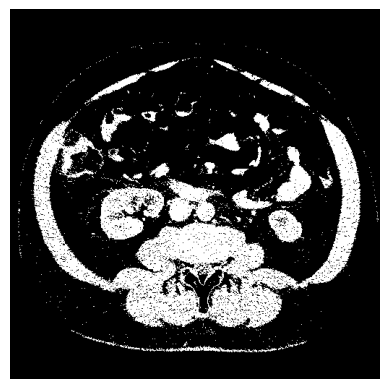

In [ ]:
hu_image, X_bone, Y_bone = show_organization_image(img_path, "liver")

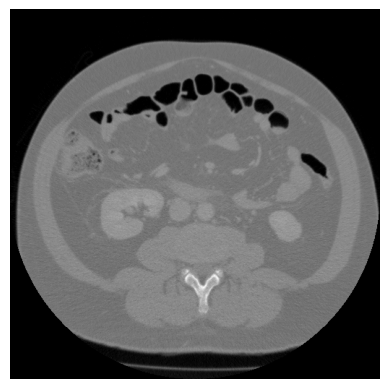

In [ ]:
show_in_gray_scale(hu_image)

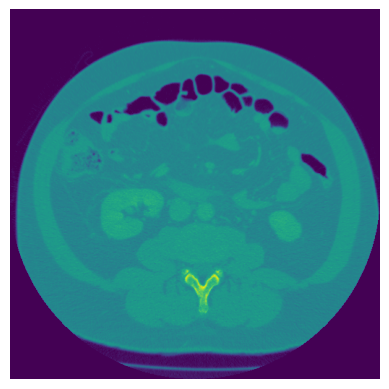

In [ ]:
dcm_format = read_dcom(img_path)
show_dicom_image(dcm_format)

In [ ]:
all_class_segments = create_contour(hu_image)

[('liver', array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]))]


In [ ]:
def liver_to_0(class_segments):
    print(class_segments[0])
    return (0, class_segments[1]) if class_segments[0] == 'liver' else class_segments


In [ ]:
all_class_segments = [liver_to_0(class_segments) for class_segments in all_class_segments]

liver


In [ ]:
all_class_segments[0][0]

0

In [ ]:
idxes = []
for idx, segment in enumerate(all_class_segments[0][1]):
  if len(segment) >= 50:
    idxes.append(idx)

In [ ]:
def support_create_txt(annot_file, contours, image):
    '''
    contours = list(class, segments)
    segments = list(x, y)
    '''
    h,w = image.shape
    res = ""
    for cls, segments in contours:

        for segment in segments:
            line = f"{cls}"
            for xy in segment:
                x,y = xy[0]
                line = line + f" {x/w} {y/h}"
            line += "\n"
            res += line
    f = open(annot_file, "w")
    f.write(res)
    f.close()

In [ ]:
support_create_txt("label.txt", all_class_segments, hu_image)

In [ ]:
from google.colab.patches import cv2_imshow

from random import randint

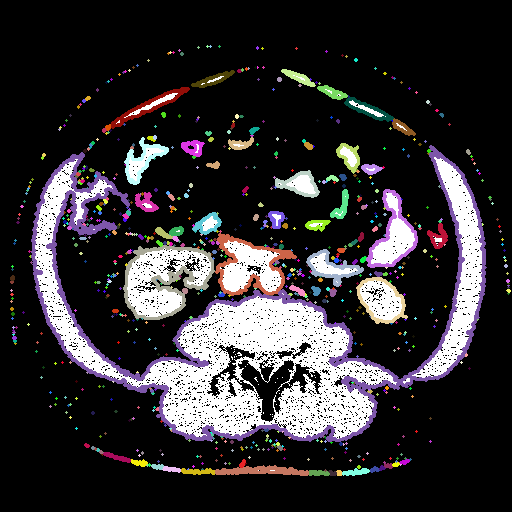

In [ ]:
draw_label_YOLOv8("output.png", "label.txt")

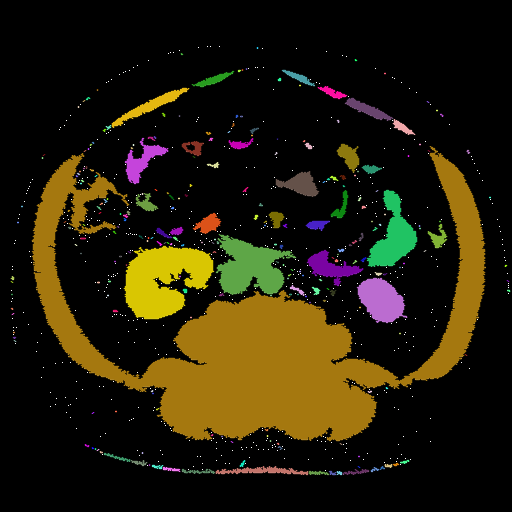

In [ ]:
draw_label_YOLOv8("output.png", "label.txt", True)

In [ ]:
os.listdir()

['6',
 '2',
 '17',
 '8',
 '4',
 '12',
 '5',
 '20',
 'output.png',
 '14',
 '10',
 '3',
 '15',
 '16',
 '9',
 '19',
 'label.txt',
 '1',
 '13',
 '11',
 '7',
 '18']

In [ ]:
!ls

1  10  11  12  13  14  15  16  17  18  19  2  20  3  4	5  6  7  8  9  label.txt  output.png


In [ ]:
%cd 1

/content/3Dircadb1/1


In [ ]:
import cv2
import numpy as np

colors = []

for i in range(19):
    hue = int(180.0 * i / 19)  # Vary the hue between 0 and 180 (OpenCV uses hue values from 0 to 180)
    color = cv2.cvtColor(np.uint8([[[hue, 255, 255]]]), cv2.COLOR_HSV2BGR)[0][0]
    colors.append((int(color[0]), int(color[1]), int(color[2])))

In [ ]:
def ctxy2xy(contour):
    x = []
    y = []
    for edge in contour:
        x.append(edge[0][0])
        y.append(edge[0][1])

    return np.array(x), np.array(y)

In [ ]:
def PolyArea(x,y):

    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [ ]:
def validContour(contour, minPixels=100):
    # print(PolyArea(*ctxy2xy(contour)))
    return PolyArea(*ctxy2xy(contour)) > minPixels

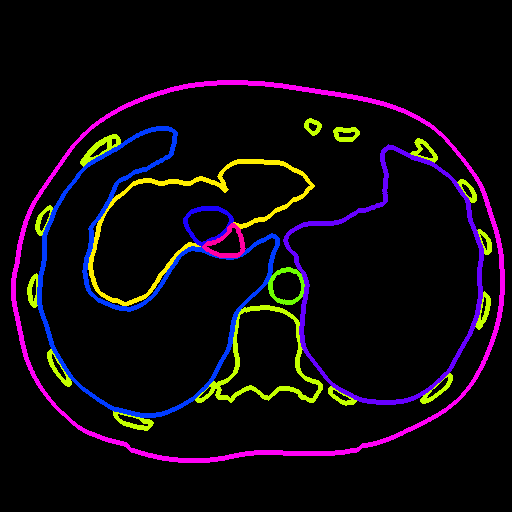

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [ ]:
def process(n, show=False, save=False, createLabel=False):
    organs = os.listdir('MASKS_DICOM')
    all_organs_file_path = f'PATIENT_DICOM/image_{n}'

    all_organs_img = transform_to_hu(read_dcom(all_organs_file_path))
    visualize_img = cv2.cvtColor(np.zeros(all_organs_img.shape, dtype=np.uint8), cv2.COLOR_GRAY2BGR)

    output_label_path = f"{n}.txt"
    output_image_path = f"{n}.png"
    txt_content = ""

    for class_idx, organ in enumerate(organs):
        # Load mask image object (2D array of 0s and 1s)
        organs_file_path = f'MASKS_DICOM/{organ}/image_{n}'
        mask_img = transform_to_hu(read_dcom(organs_file_path))

        # Create contours on the mask image
        mask_img = np.array(mask_img, np.uint8)
        contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = filter(
            validContour,
            contours
        )
        # Generate yolov8 notation
        h,w = mask_img.shape
        for contour in contours:

            segment = []

            line = f"{class_idx}"
            for xy in contour:
                x,y = xy[0]
                line = line + f" {x/w} {y/h}"

                segment.append(xy[0])

            line += "\n"
            txt_content += line

            segment = np.array(segment, np.int32).reshape(-1, 1, 2)
            cv2.polylines(visualize_img, [segment], isClosed=True, color=colors[class_idx], thickness=3)

    if createLabel:
        with open(output_label_path, 'w') as f:
            f.write(txt_content)

    if save:
        cv2.imwrite(output_image_path, visualize_img)

    # draw_label_YOLOv8(output_image_path, output_image_path, True)
    if show:
        cv2_imshow(visualize_img)
    return visualize_img


process(120, show=True)


In [ ]:
!pwd

/content/3Dircadb1/1


In [ ]:
%cd ..

/content/3Dircadb1


In [ ]:
!pwd

/content/3Dircadb1


In [ ]:
import cv2
import os
from tqdm import tqdm

def create_video(id):
    %cd '{id}'
    first_contour_img = process(0)

    w, h, _ = first_contour_img.shape
    w *= 2

    fps = 20
    video_writer = cv2.VideoWriter(f'{id}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

    total_frame = len(os.listdir('PATIENT_DICOM/'))
    with tqdm(total=total_frame, desc="Creating video...") as pbar:
        for frame_number in range(total_frame):
            contour_img = process(frame_number)

            all_organs_file_path = f'PATIENT_DICOM/image_{frame_number}'
            all_organs_img = transform_to_hu(read_dcom(all_organs_file_path))
            all_organs_img = cv2.convertScaleAbs(all_organs_img)
            all_organs_img = cv2.cvtColor(all_organs_img, cv2.COLOR_GRAY2BGR)
            frame = np.concatenate((contour_img, all_organs_img), axis=1)
            video_writer.write(frame)
            pbar.update(1)  # Update the progress bar after each frame

    %cd ..
    video_writer.release()


# Label and image folder

In [ ]:
def create_label_and_image(patient: int, n: int, organs: list[str], datasetName="dataset"):
    patient = str(patient)

    all_organs_file_path = os.path.join(patient, 'PATIENT_DICOM', f'image_{n}')

    all_organs_img = transform_to_hu(read_dcom(all_organs_file_path))
    visualize_img = cv2.cvtColor(np.zeros(all_organs_img.shape, dtype=np.uint8), cv2.COLOR_GRAY2BGR)

    output_label_path = f"{patient}.{n}.txt"
    output_image_path = f"{patient}.{n}.png"
    txt_content = ""

    for class_idx, organ in enumerate(organs):
        # Load mask image object (2D array of 0s and 1s)
        if organ not in os.listdir(os.path.join(patient, "MASKS_DICOM")):
            print(f"!! Patient {patient} doesn't have organ [{organ}] !!")
            continue

        organs_file_path = os.path.join(patient, 'MASKS_DICOM', organ, f'image_{n}')
        mask_img = transform_to_hu(read_dcom(organs_file_path))

        # Create contours on the mask image
        mask_img = np.array(mask_img, np.uint8)
        contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = filter(
            validContour,
            contours
        )
        # Generate yolov8 notation
        h,w = mask_img.shape
        for contour in contours:

            segment = []

            line = f"{class_idx}"
            for xy in contour:
                x,y = xy[0]
                line = line + f" {x/w} {y/h}"

                segment.append(xy[0])

            line += "\n"
            txt_content += line

            segment = np.array(segment, np.int32).reshape(-1, 1, 2)
            cv2.polylines(visualize_img, [segment], isClosed=True, color=colors[class_idx], thickness=3)

    all_organs_file_path = os.path.join(patient, 'PATIENT_DICOM', f'image_{n}')
    all_organs_img = transform_to_hu(read_dcom(all_organs_file_path))
    all_organs_img = cv2.convertScaleAbs(all_organs_img)
    all_organs_img = cv2.cvtColor(all_organs_img, cv2.COLOR_GRAY2BGR)

    with open(f'{datasetName}/{output_label_path}', 'w') as f:
        f.write(txt_content)
    cv2.imwrite(f'{datasetName}/{output_image_path}', all_organs_img)


In [ ]:
from tqdm import tqdm

In [ ]:
import shutil
shutil.rmtree('dataset', ignore_errors=True)

In [ ]:
os.makedirs('dataset')

In [ ]:
organs_set = set()

In [ ]:
!mkdir dataset
for patient in range(1,21):
  n_images = len(os.listdir(os.path.join(str(patient), 'PATIENT_DICOM')))
  print(f"Patient {patient} has {n_images} images.")
  with tqdm(total=n_images, desc=f"Creating labels and images for patient {patient}...") as pbar:
    for i in range(n_images):
      create_label_and_image(patient, i, organs=['liver'])
      pbar.update(1)


mkdir: cannot create directory ‘dataset’: File exists
Patient 1 has 129 images.


Creating labels and images for patient 1...: 100%|██████████| 129/129 [00:03<00:00, 33.85it/s]


Patient 2 has 172 images.


Creating labels and images for patient 2...: 100%|██████████| 172/172 [00:04<00:00, 40.15it/s]


Patient 3 has 200 images.


Creating labels and images for patient 3...: 100%|██████████| 200/200 [00:04<00:00, 46.17it/s]


Patient 4 has 91 images.


Creating labels and images for patient 4...: 100%|██████████| 91/91 [00:02<00:00, 37.12it/s]


Patient 5 has 139 images.


Creating labels and images for patient 5...: 100%|██████████| 139/139 [00:07<00:00, 18.89it/s]


Patient 6 has 135 images.


Creating labels and images for patient 6...: 100%|██████████| 135/135 [00:03<00:00, 38.74it/s]


Patient 7 has 151 images.


Creating labels and images for patient 7...: 100%|██████████| 151/151 [00:03<00:00, 48.75it/s]


Patient 8 has 124 images.


Creating labels and images for patient 8...: 100%|██████████| 124/124 [00:02<00:00, 44.73it/s]


Patient 9 has 111 images.


Creating labels and images for patient 9...: 100%|██████████| 111/111 [00:02<00:00, 37.46it/s]


Patient 10 has 122 images.


Creating labels and images for patient 10...: 100%|██████████| 122/122 [00:03<00:00, 35.50it/s]


Patient 11 has 132 images.


Creating labels and images for patient 11...: 100%|██████████| 132/132 [00:02<00:00, 49.24it/s]


Patient 12 has 260 images.


Creating labels and images for patient 12...: 100%|██████████| 260/260 [00:05<00:00, 49.58it/s]


Patient 13 has 122 images.


Creating labels and images for patient 13...: 100%|██████████| 122/122 [00:03<00:00, 36.05it/s]


Patient 14 has 113 images.


Creating labels and images for patient 14...: 100%|██████████| 113/113 [00:03<00:00, 33.75it/s]


Patient 15 has 125 images.


Creating labels and images for patient 15...: 100%|██████████| 125/125 [00:02<00:00, 49.65it/s]


Patient 16 has 155 images.


Creating labels and images for patient 16...: 100%|██████████| 155/155 [00:03<00:00, 40.85it/s]


Patient 17 has 119 images.


Creating labels and images for patient 17...: 100%|██████████| 119/119 [00:02<00:00, 46.43it/s]


Patient 18 has 74 images.


Creating labels and images for patient 18...: 100%|██████████| 74/74 [00:01<00:00, 57.74it/s]


Patient 19 has 124 images.


Creating labels and images for patient 19...: 100%|██████████| 124/124 [00:02<00:00, 46.39it/s]


Patient 20 has 225 images.


Creating labels and images for patient 20...: 100%|██████████| 225/225 [00:04<00:00, 49.05it/s]


In [ ]:
print(f"This dataset have {len(os.listdir('dataset'))/2} image")

This dataset have 2823.0 image


In [ ]:
DATASET_NAME = 'liver'

In [ ]:
!mkdir {DATASET_NAME}
!mkdir {DATASET_NAME}/train
!mkdir {DATASET_NAME}/valid
!mkdir {DATASET_NAME}/test

!mkdir {DATASET_NAME}/train/images
!mkdir {DATASET_NAME}/valid/images
!mkdir {DATASET_NAME}/test/images
!mkdir {DATASET_NAME}/train/labels
!mkdir {DATASET_NAME}/valid/labels
!mkdir {DATASET_NAME}/test/labels

In [ ]:
yaml_content = ""
yaml_content += "names:\n"
for organ in ['liver']:
    yaml_content += f"- {organ}\n"
yaml_content += f"nc: 1\n"
yaml_content += "train: train/images\n"
yaml_content += "val: valid/images\n"
yaml_content += "test: test/images\n"

with open(f"{DATASET_NAME}/data.yaml", 'w') as f:
    f.write(yaml_content)


In [ ]:
tvtratio = [.7, .2, .1] # train, valid, test


In [ ]:
import numpy as np

with tqdm(total=len(os.listdir('dataset'))/2, desc=f"Randomizing train/valid/test...") as pbar:
    for f in os.listdir("dataset"):
        id = f[:-4]
        if f.endswith('.txt'):
            continue

        r = np.random.uniform(0, 1)
        if r < tvtratio[0]: split = 'train'
        elif r < tvtratio[0] + tvtratio[1]: split = 'valid'
        else: split = 'test'

        destination = os.path.join(DATASET_NAME, split)

        !cp dataset/{id + '.png'} {destination}/images
        !cp dataset/{id + '.txt'} {destination}/labels

        pbar.update(1)


Randomizing train/valid/test...: 100%|██████████| 2823/2823.0 [09:47<00:00,  4.80it/s]


In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO

from IPython.display import display, Image

Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.3/78.2 GB disk)


In [ ]:
%cd /content
!yolo task=segment mode=train model=yolov8l-seg.pt data=/content/3Dircadb1/liver/data.yaml epochs=20 batch=20

/content
Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8l-seg.pt, data=/content/3Dircadb1/liver/data.yaml, epochs=20, time=None, patience=50, batch=20, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

In [ ]:
!pwd

/content


In [ ]:
model=YOLO("runs/segment/train2/weights/best.pt")

In [ ]:
%cd 3Dircadb1/liver

/content/3Dircadb1/liver


In [ ]:
%cd test

/content/3Dircadb1/liver/test


In [ ]:
%cd images

/content/3Dircadb1/liver/test/images


In [ ]:
images_path = os.listdir()
print(images_path)

['16.137.png', '16.126.png', '14.93.png', '11.67.png', '8.113.png', '14.4.png', '17.37.png', '2.104.png', '2.42.png', '16.64.png', '2.2.png', '13.14.png', '18.53.png', '18.26.png', '2.72.png', '2.37.png', '20.105.png', '3.8.png', '18.29.png', '7.29.png', '17.17.png', '6.72.png', '4.39.png', '1.122.png', '12.143.png', '5.87.png', '10.101.png', '3.17.png', '13.59.png', '1.14.png', '2.134.png', '15.24.png', '2.122.png', '16.132.png', '5.5.png', '14.82.png', '16.66.png', '9.95.png', '5.57.png', '17.66.png', '15.50.png', '12.230.png', '3.137.png', '9.83.png', '12.231.png', '12.8.png', '1.40.png', '3.104.png', '12.35.png', '5.62.png', '2.59.png', '14.88.png', '12.116.png', '7.147.png', '7.11.png', '5.94.png', '19.48.png', '3.31.png', '10.32.png', '8.80.png', '17.106.png', '4.46.png', '6.49.png', '15.97.png', '9.26.png', '6.79.png', '12.249.png', '14.60.png', '12.41.png', '11.107.png', '10.113.png', '17.34.png', '20.187.png', '5.24.png', '17.27.png', '7.142.png', '20.68.png', '14.8.png', '12.

In [ ]:
model.predict(images_path[10:20],save=True,conf=0.5,show_boxes=False)


0: 640x640 (no detections), 1: 640x640 (no detections), 2: 640x640 1 liver, 3: 640x640 2 livers, 4: 640x640 1 liver, 5: 640x640 (no detections), 6: 640x640 (no detections), 7: 640x640 (no detections), 8: 640x640 2 livers, 9: 640x640 (no detections), 483.5ms
Speed: 4.2ms preprocess, 48.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'liver'}
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
    

##Save dataset

In [ ]:
%cd /content

/content


In [ ]:
os.makedirs('/content/gdrive/MyDrive/Assignment 3: Segmentation with Deep Learning/dataset')

In [ ]:
!cp -r 3Dircadb1/dataset/. /content/gdrive/MyDrive/Assignment\ 3:\ Segmentation\ with\ Deep\ Learning/dataset

In [ ]:
!cp -r runs/segment/train2/. /content/gdrive/MyDrive/Assignment\ 3:\ Segmentation\ with\ Deep\ Learning